# CAB420, DCNNs, Additional Example 5: Model Variation
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

Neural networks contain a lot of parameters, typically in the order of hundreds of thousands, or millions. Typically, these paraemters are randomly initialised, and then data is fed to the model is a random order. This means that each time a network is trained, you will get a slightly different network. Generally, if you're network is appropriate and you have sufficient data, results over multiple trials will be fairly similar, but they will be different. This example explores this, and looks at how we can combine multiple models to get a small increase in accuracy.

It should be noted, there is a lot of research on model ensembles. This example is a very superficial look at this idea - but it is an idea that has a lot of interest and possibilities.

## Too Long; Didn't Read

When we train a DCNN:
* Weights and biases are randomly initialised
* Data is shuffled between epochs and fed to the model in a random order

This means that each training run results in a slightly different model, and models will make slightly different predictions, sometimes this might be:
* a small change in the softmax score
* a large change in the final layer that results in a different decision
However, assuming the model is not too huge and is trained for long enough, overall performance (i.e accuracy) will be stable across the different models.

If we average model results however, we can correct some of the errors our model makes. We can also use this to help estimate model uncertainty. Although, we see a number of examples where all our models are extremely confident in their incorrect decision, so this is a not a silver bullet for estimating confidence, or correcting errors. 

A downside to this approach is also the increase in resources. In the ensemble we've trained here we have 10 models. Each model is simple, but we still have 10 of them. Using more models might help us better estimate uncertainty and give a small performance gain, but we will suffer diminishing returns doing this.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import datetime
import numpy

import keras as keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import seaborn as sns

## Data Setup

We're using Fashion MNIST here. The setup is the same as we've used elsewhere for DCNNs.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

## Network Setup

We're now going to setup our network. We'll use the simple DCNN from the second DCNN example. This is fairly compact DCNN, that will train in ~2 minutes and get to about ~88-90% accuracy.

In [3]:
def simple_fmnist_cnn():
    # our input now has a different shape, 28x28x1, as we have 28x28 single channel images
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    # rather than use a fully connected layer, we'll use 2D convolutional layers, 8 filters, 3x3 size kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
    # 2x2 max pooling, this will downsample the image by a factor of two
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # more convolution, 16 filters, followed by max poool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final convolution, 32 filters
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    # a flatten layer. Matlab does a flatten automatically, here we need to explicitly do this. Basically we're telling
    # keras to make the current network state into a 1D shape so we can pass it into a fully connected layer
    x = layers.Flatten()(x)
    # a single fully connected layer, 64 inputs
    x = layers.Dense(64, activation='relu')(x)
    # and now our output, same as last time
    outputs = layers.Dense(10, activation='softmax')(x)

    # build the model, and print the summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
    return model_cnn

## Network Training

We'll train multiple models here, simply via a for loop. I'm using the same settings I've used elsewhere, but I've set the call to ``fit`` to use ``verbose=False`` to avoid having too much text generated.

All networks will be trained for the same period of time, but each network will have a different random initialisation of weights, and a different order of data fed into the network.

**NOTE: Adjust number of models to be trained according to your environment!**

In [4]:
models = []
histories = []
#
# NOTE: Adjust this parameter according to your envionment. On the QUT-hosted JupyterLab GPU Instance you will
# need to make this smaller
#
num_models = 10
epochs = 20
batch_size = 64

for i in range(num_models):

    print('Training model %d/%d' % (i + 1, num_models))
    m = simple_fmnist_cnn()
    m.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'], jit_compile=False)
    h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=False)
    
    models.append(m)
    histories.append(h)

Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10


### Training Results

As a sanity check, we'll plot some training and validation curves for loss and accuracy. We expect to see pretty similar curves for all the models we've trained.

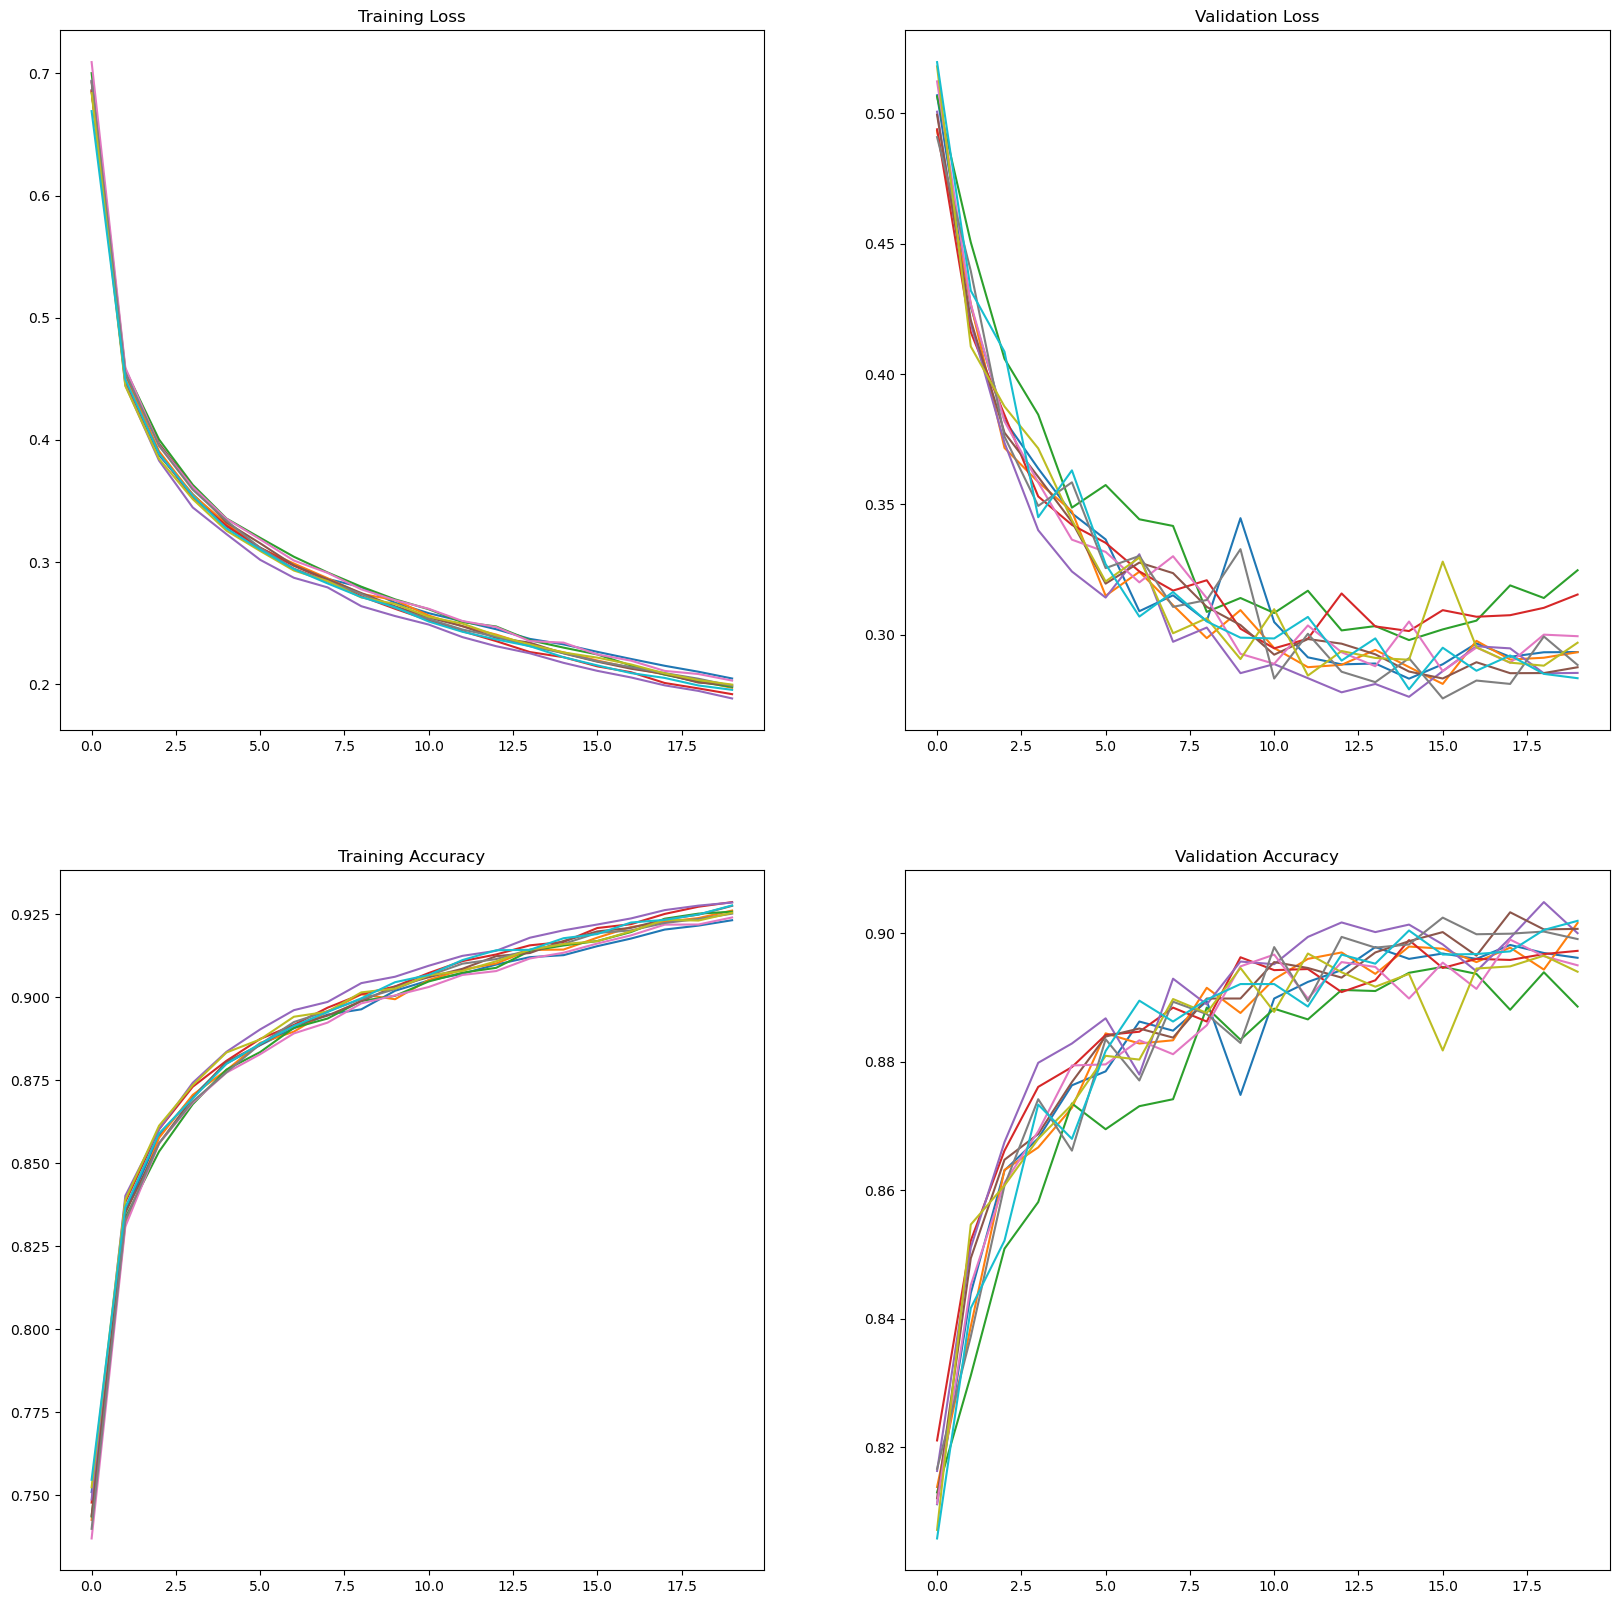

In [5]:
def plot_training(histories):
    fig = plt.figure(figsize=[20, 20])

    ax = fig.add_subplot(2, 2, 1)
    for i in range(num_models):
        ax.plot(histories[i].history['loss'])
    ax.set_title('Training Loss')

    ax = fig.add_subplot(2, 2, 2)
    for i in range(num_models):
        ax.plot(histories[i].history['val_loss'])
    ax.set_title('Validation Loss')

    ax = fig.add_subplot(2, 2, 3)
    for i in range(num_models):
        ax.plot(histories[i].history['accuracy'])
    ax.set_title('Training Accuracy')

    ax = fig.add_subplot(2, 2, 4)
    for i in range(num_models):
        ax.plot(histories[i].history['val_accuracy'])
    ax.set_title('Validation Accuracy')
        
plot_training(histories)

From the above plots, all of our models are looking fairly simmilar. Training curves look very close. There is slightly more variation for the validation curves, but accuracy is still within about 1% for all models. We can look at this a bit closer by evaluating each model on the test set.

In [6]:
preds = []
indexes = []
for i in range(num_models):
    print('Model %d' % (i + 1))
    test_scores = models[i].evaluate(x_test, y_test, verbose=2)
    p = models[i].predict(x_test)
    idx = numpy.argmax(p, axis = 1)
    preds.append(p)
    indexes.append(idx)

Model 1
313/313 - 1s - 3ms/step - accuracy: 0.8934 - loss: 0.3034
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Model 2
313/313 - 0s - 1ms/step - accuracy: 0.8968 - loss: 0.3051
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 3
313/313 - 0s - 1ms/step - accuracy: 0.8848 - loss: 0.3312
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 4
313/313 - 0s - 1ms/step - accuracy: 0.8938 - loss: 0.3210
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 5
313/313 - 0s - 1ms/step - accuracy: 0.8977 - loss: 0.2948
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 6
313/313 - 0s - 1ms/step - accuracy: 0.8943 - loss: 0.3052
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 7
313/313 - 0s - 1ms/step - accuracy: 0.8896 - loss: 0.3106
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 8
313/313 - 0s - 1ms/step - accuracy: 0.8931 - loss: 0.3042
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 9
313/313 - 0s - 1ms/step - accuracy: 0.8896 - loss: 0.3080
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model 10
313/313 - 0s - 1ms/step - ac

Again, we see results are, on the whole, very similar. All models are within about 1% accuracy.

### An Average Model and Variation in Error Cases

We can also take the average results. We can do this in a couple of ways:
* We could take a consensus approach, i.e. look at the decision made by each model and give each model a vote
* We could average the softmax scores, and then look the maximum value within those

We'll go the second approach.

In [7]:
average_prediction = numpy.mean(numpy.asarray(preds), axis = 0)
average_idx = numpy.argmax(average_prediction, axis = 1)

We'll now look at some specific samples and see how things vary, and what the average model produces in these cases. Here, we will look at samples that the first model in our set classifies incorrectly.

In [8]:
num_to_check = 50
for i in range(num_to_check):
    if (indexes[0][i] != y_test[i]):
        print('Index %d; True Class: %d' % (i, y_test[i]))
        for j in range(num_models):
            print('\tModel %d, Predicted class %d (%f)' % (j + 1, indexes[j][i], preds[j][i][indexes[j][i]]))
        print('\tAverage Model, Predicted class %d (%f)' % (average_idx[i], average_prediction[i][average_idx[i]]))

Index 21; True Class: 5
	Model 1, Predicted class 7 (0.594574)
	Model 2, Predicted class 7 (0.860705)
	Model 3, Predicted class 7 (0.538956)
	Model 4, Predicted class 7 (0.893219)
	Model 5, Predicted class 5 (0.822043)
	Model 6, Predicted class 5 (0.607015)
	Model 7, Predicted class 5 (0.784331)
	Model 8, Predicted class 5 (0.870855)
	Model 9, Predicted class 5 (0.937342)
	Model 10, Predicted class 5 (0.949357)
	Average Model, Predicted class 5 (0.607591)
Index 23; True Class: 9
	Model 1, Predicted class 5 (0.999992)
	Model 2, Predicted class 5 (0.999999)
	Model 3, Predicted class 5 (0.999969)
	Model 4, Predicted class 5 (0.997917)
	Model 5, Predicted class 5 (0.999860)
	Model 6, Predicted class 5 (0.999923)
	Model 7, Predicted class 5 (0.999967)
	Model 8, Predicted class 5 (0.999883)
	Model 9, Predicted class 5 (0.999999)
	Model 10, Predicted class 5 (1.000000)
	Average Model, Predicted class 5 (0.999751)
Index 25; True Class: 4
	Model 1, Predicted class 2 (0.768479)
	Model 2, Predict

/tmp/ipykernel_652241/2283986500.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Index %d; True Class: %d' % (i, y_test[i]))


What we see is that in most cases, some models in the set disagree with each other. There are situations where all or the majority of models make the same error, but even in those cases we see variation in the softmax scores. 

More often, for these examples we see variation in the decision of a model, and we see some models getting the answer right, and others being wrong. Looking at the results of the average model, we see that it's sometimes able to correct an error. Even in situations where this doesn't happen, the softmax score for the predicted class is a bit lower than for many of the individual models, indicating a lower amount of confidence from the model.

### The Wisdom of the Crowd

If we look at the accuracy of our average model (an ensemble of models), we get an interesting result:

In [9]:
print(sum(average_idx == y_test[:,0]) / len(y_test))

0.9177


It's actually slightly more accurate than any individual model, gaining ~2% accuracy. The model is still no where near perfect, but this is a substantial jump in performance.

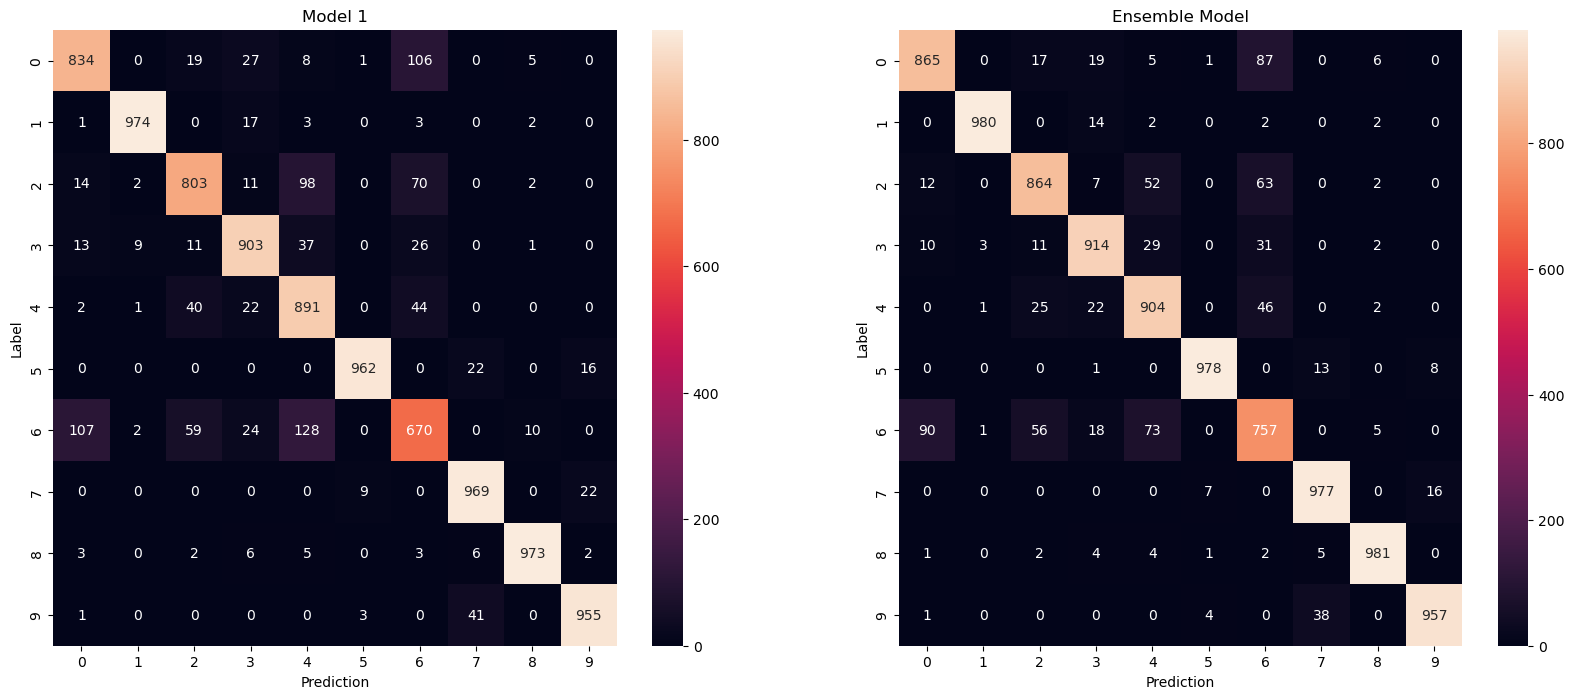

In [10]:
confusion_mtx = confusion_matrix(y_test, indexes[0]) 
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Model 1')

confusion_mtx = confusion_matrix(y_test, average_idx) 
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Ensemble Model');

If we compare a single model to the ensemble, we see that the ensemble is not universally better across all classes. There are errors made by the ensemble that the individual model get's right - but there are more errors that are corrected.

This process can be seen as being similar to the logic behind a random forest, i.e. we're taking a consensus result from a number of noisey classifiers. Of course there's a few large differences between this approach and a random forest:
* We haven't performed bagging or other such techniques, and it's hard to imagine that our individual classifiers are independant of each other (we could try to rectify this with feature selection methods however)
* Each of our component classifiers (i.e. each DCNN) is way more complex than an equivilent entire Random Forest; the entire ensemble is an order of magnitude more complex again.

## Final Thoughts

Model ensembles such as what we have here are an idea that is become more popular. There are obvious downsides around the resulting complexity and training time requirements, but they also provide a means to get a small accuracy boost, and perhaps more importantly provide a better definition of uncertainty that we'd get for a softmax layer alone. 

The idea of estimating uncertainty (or confidence) from a DCNN is something that's becoming increasingly important as we seek to understand why a machine learning model makes the decision that it does. There are other approaches to help estimate uncertainty, such as test-time dropout, and research fields such as Bayesian Neural Networks; however these are also imperfect approaches for their own reasons.

So given the above, what have we learnt today?

Probably the most critical thing is that neural networks vary a fair bit across training runs. They may all end up with similar performance, but individual results (particular for hard to classify samples) can vary a lot - and the average results across a set of models can be more accurate than the individual models.